In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline

!pip install -q catboost
from catboost import CatBoostClassifier

In [2]:
job = pd.read_csv('/kaggle/input/job-placement-dataset/Job_Placement_Data.csv')
print(job.shape)
job.head()

(215, 13)


,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


In [3]:
job.status = job.status.map({'Placed': 1, 'Not Placed': 0})

Перед началом обучения я хочу проверить, есть ли данные, не влияющие на **status**

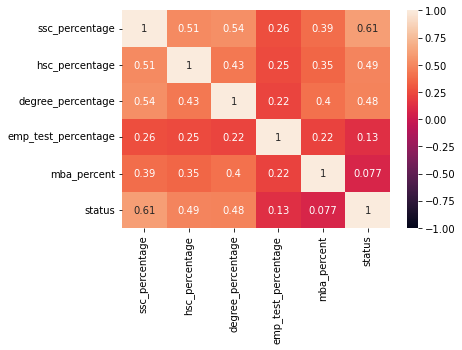

In [4]:
sns.heatmap(job.corr(), xticklabels=job.corr().columns, yticklabels=job.corr().columns,
            vmin=-1, vmax=1, annot=True)
plt.show()

Параметры **emp_test_percentage** и **mba_percent** слабо коррелируют с **status**, поэтому будут удалены

In [5]:
target = job.status
job = job.drop(columns=['emp_test_percentage','mba_percent','status'])

In [6]:
job = pd.get_dummies(job)
job.head()

,ssc_percentage,hsc_percentage,degree_percentage,gender_F,gender_M,ssc_board_Central,ssc_board_Others,hsc_board_Central,hsc_board_Others,hsc_subject_Arts,hsc_subject_Commerce,hsc_subject_Science,undergrad_degree_Comm&Mgmt,undergrad_degree_Others,undergrad_degree_Sci&Tech,work_experience_No,work_experience_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,67.00,91.00,58.00,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,1
1,79.33,78.33,77.48,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0
2,65.00,68.00,64.00,0,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0
3,56.00,52.00,52.00,0,1,1,0,1,0,0,0,1,0,0,1,1,0,0,1
4,85.80,73.60,73.30,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0


In [7]:
x_train, x_test, y_train, y_test = train_test_split(job, target, test_size=0.3)

Мне интересно посмотреть, как стандартизация будет влиять на оценку, поэтому я сравню **StandardScaler, Normalizer** и **MinMaxScaler**

In [8]:
stand_name = (StandardScaler(), Normalizer(), MinMaxScaler())

In [9]:
for sn in stand_name:
    check_st = make_pipeline(sn, CatBoostClassifier(verbose=False))
    check_st.fit(x_train, y_train)
    y_predict = check_st.predict(x_test)
    
    print('**********************************************')
    print(sn)
    print(classification_report(y_test, y_predict))
    print(f'roc-auc score: {roc_auc_score(y_test,y_predict):.5f}')
    print('**********************************************\n')

**********************************************
StandardScaler()
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.87      0.93      0.90        43

    accuracy                           0.86        65
   macro avg       0.86      0.83      0.84        65
weighted avg       0.86      0.86      0.86        65

roc-auc score: 0.82875
**********************************************

**********************************************
Normalizer()
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        22
           1       0.83      0.91      0.87        43

    accuracy                           0.82        65
   macro avg       0.80      0.77      0.78        65
weighted avg       0.81      0.82      0.81        65

roc-auc score: 0.77167
**********************************************

**********************************************
MinMaxScaler()
              prec

Наибольшая оценка у **StandardScaler** и **MinMaxScaler**, поэтому для работы возьму **MinMaxScaler**

In [10]:
nm = ['ssc_percentage','hsc_percentage','degree_percentage']
sc = MinMaxScaler()
x_train[nm] = sc.fit_transform(x_train[nm])
x_test[nm] = sc.fit_transform(x_test[nm])
x_train.head()

,ssc_percentage,hsc_percentage,degree_percentage,gender_F,gender_M,ssc_board_Central,ssc_board_Others,hsc_board_Central,hsc_board_Others,hsc_subject_Arts,hsc_subject_Commerce,hsc_subject_Science,undergrad_degree_Comm&Mgmt,undergrad_degree_Others,undergrad_degree_Sci&Tech,work_experience_No,work_experience_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
168,0.146568,0.190641,0.195122,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1
87,0.385694,0.190641,0.243902,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,1
80,0.579468,0.381282,0.463415,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1
66,0.868068,0.589255,0.390244,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,1
83,0.888683,0.675910,0.439024,0,1,0,1,0,1,0,0,1,0,0,1,0,1,1,0


In [11]:
cbc1 = CatBoostClassifier(verbose=False)
params = {'iterations': range(100,501,100),
          'depth': range(2,8)}
gs = GridSearchCV(cbc1, params)
gs.fit(x_train, y_train)
gs.best_params_

{'depth': 4, 'iterations': 400}

Использую GridSearchCV для подбора параметров классфикатора. Честно говоря, я не очень довольна, что параметр **depth** равен 2. Вполне возможно это происходит из-за малого объема данных

In [12]:
cbc2 = CatBoostClassifier(iterations=200, depth=2, verbose=False)
cbc2.fit(x_train, y_train)
y_predict = cbc2.predict(x_test)
print(classification_report(y_test, y_predict))
print(f'roc-auc score: {roc_auc_score(y_test,y_predict):.5f}')

              precision    recall  f1-score   support

           0       0.94      0.68      0.79        22
           1       0.86      0.98      0.91        43

    accuracy                           0.88        65
   macro avg       0.90      0.83      0.85        65
weighted avg       0.88      0.88      0.87        65

roc-auc score: 0.82928


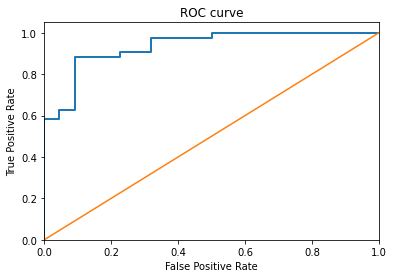

In [13]:
fpr, tpr, thresholds = roc_curve(y_test,cbc2.predict_proba(x_test)[:,1], pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve')
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Так же интресно посмотреть на значимость каждого столбца

In [14]:
new_df = pd.DataFrame(data={'feature_name':cbc2.feature_names_,
                            'importance':cbc2.feature_importances_})\
.sort_values(by='importance', ascending=False)
new_df

,feature_name,importance
0,ssc_percentage,29.211575
1,hsc_percentage,26.812770
2,degree_percentage,23.560926
3,gender_F,4.028283
16,work_experience_Yes,3.561355
15,work_experience_No,3.027869
4,gender_M,2.729602
18,specialisation_Mkt&HR,1.817991
17,specialisation_Mkt&Fin,1.778634
5,ssc_board_Central,1.046536


Как видно, есть столбцы с не высоким влиянием на результат классификации, поэтому выберу 80% наиболее значимых параметров 

In [15]:
per80 = round(len(new_df)*0.8)
max80 = new_df.head(per80)
max80

,feature_name,importance
0,ssc_percentage,29.211575
1,hsc_percentage,26.812770
2,degree_percentage,23.560926
3,gender_F,4.028283
16,work_experience_Yes,3.561355
15,work_experience_No,3.027869
4,gender_M,2.729602
18,specialisation_Mkt&HR,1.817991
17,specialisation_Mkt&Fin,1.778634
5,ssc_board_Central,1.046536


Строю новую модель, но уже с отобранными ранее параметрами. Оценка ожидаемо повысилась

In [16]:
cbc3 = CatBoostClassifier(iterations=200, depth=2, verbose=False)
cbc3.fit(x_train[max80.feature_name], y_train)
y_predict3 = cbc3.predict(x_test[max80.feature_name])
print(classification_report(y_test, y_predict3))
print(f'roc-auc score: {roc_auc_score(y_test,y_predict3):.5f}')

              precision    recall  f1-score   support

           0       0.94      0.68      0.79        22
           1       0.86      0.98      0.91        43

    accuracy                           0.88        65
   macro avg       0.90      0.83      0.85        65
weighted avg       0.88      0.88      0.87        65

roc-auc score: 0.82928


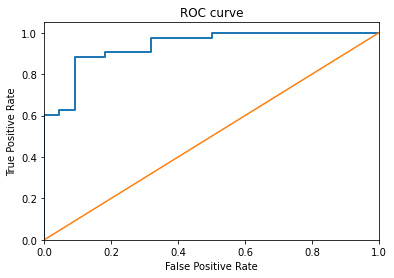

In [17]:
y_predict_proba3 = cbc3.predict_proba(x_test[max80.feature_name])[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_predict_proba3, pos_label=1)
plt.plot(fpr, tpr, lw=2, label='ROC curve')
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()